In [1]:
from astropy.io import fits
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [3]:
import os

In [149]:
import sys
sys.path.append('../../tools/')
from dust_extinction import calALambda
from data_binning import data_binning

In [4]:
Sci_folder = 'keck_deimos_pypeit/Science/'
ls = [
    i for i in os.listdir(Sci_folder)
    if ('SN2020jgb' in i and 'fits' in i and 'spec1d' in i)
]
ls_cal = [
    i for i in os.listdir(Sci_folder)
    if ('HZ' in i and 'fits' in i and 'spec1d' in i)
]

## Standard stars

In [5]:
f = fits.open(Sci_folder+ls_cal[0])
f.info()
print(repr(f[0].header))
f.close()

Filename: keck_deimos_pypeit/Science/spec1d_d0331_0030-HZ44_DEIMOS_20220331T104910.934.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  SPAT0931-SLIT0947-DET03    1 BinTableHDU     80   4096R x 22C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  2  SPAT0931-SLIT0948-DET07    1 BinTableHDU     80   4096R x 22C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  3  DET03-DETECTOR    1 BinTableHDU     34   1R x 2C   [1D, 1D]   
  4  DET07-DETECTOR    1 BinTableHDU     34   1R x 2C   [1D, 1D]   
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
VERSPYT = '3.

In [6]:
output = 'spec1d_d0331_0030-HZ44_DEIMOS_20220331T104910.934.fits'
output = 'spec1d_d0'
#os.system('cp {} {}'.format(Sci_folder + ls_cal[0], Sci_folder + output))

[3914.74953834 3915.34609819] [6478.02504701 6478.67431832]
[3913.16744135 3913.77082746] [6480.30468813 6480.9516352 ]
[6491.73228022 6492.3795526 ] [9124.42931412 9125.06087826]
[6494.1867373  6494.83207539] [9127.47995328 9128.11796444]


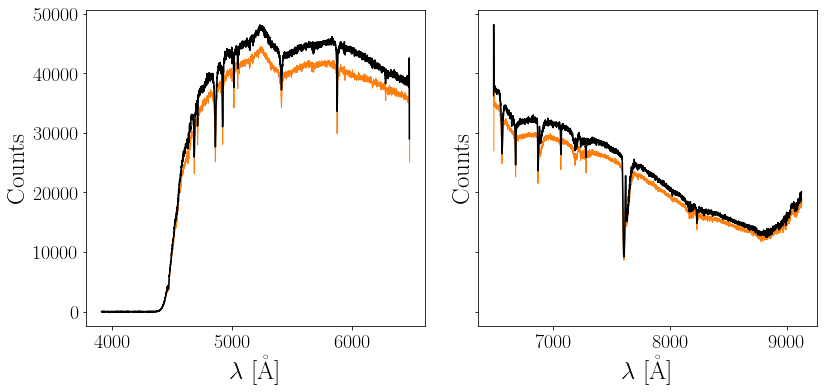

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax = ax.flatten()
for k in np.arange(2) + 1:
    Wav = None
    Counts = None
    Mask = None
    for m, l in enumerate(ls_cal):
        f = fits.open(Sci_folder + l)
        specdata = f[k].data
        mask = specdata['OPT_MASK']
        wav = specdata['OPT_WAVE']
        counts = specdata['OPT_COUNTS']
        print(wav[mask][0:2], wav[mask][-3:-1])
        f.close()
        
        ###co-adding
        if m == 0:
            Wav = wav
            Counts = counts
            Mask = mask
        elif m != 1:
            Wav += wav
            Counts += counts
            Mask = [i and j for (i, j) in zip(Mask, mask)]
        #plt.xlim(wav[wav > 8200][0], wav[wav > 8200][-1])
        ax[k-1].plot(wav[mask], counts[mask], linewidth=1)
    Wav = Wav/(len(ls_cal)-1)
    Counts = Counts/(len(ls_cal)-1)
    ax[k-1].set_xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
    ax[k-1].set_ylabel(r'$\mathrm{Counts}$')
    
    with fits.open(Sci_folder + output, 'update') as fout:
        fout[k].data['OPT_MASK'] = Mask
        fout[k].data['OPT_WAVE'] = Wav
        fout[k].data['OPT_COUNTS'] = Counts
        fout.flush()
        
    with fits.open(Sci_folder + output) as fout:
        mask = fout[k].data['OPT_MASK']
        wav = fout[k].data['OPT_WAVE']
        counts = fout[k].data['OPT_COUNTS']
        ax[k-1].plot(wav[mask], counts[mask], color='k')
fig.tight_layout()
plt.show()

## Sensitivity function

Filename: keck_deimos_pypeit/Fluxing/Keck_DEIMOS_sens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  SENS          1 BinTableHDU     59   2R x 11C   [4096D, 4096D, 4096D, 4096L, 4096D, 4096L, D, K, K, D, D]   
  2  WAVE          1 ImageHDU        19   (1, 16317)   float64   
  3  ZEROPOINT     1 ImageHDU        19   (1, 16317)   float64   
  4  THROUGHPUT    1 ImageHDU        19   (1, 16317)   float64   
None
(numpy.record, [('SENS_WAVE', '>f8', (4096,)), ('SENS_COUNTS_PER_ANG', '>f8', (4096,)), ('SENS_ZEROPOINT', '>f8', (4096,)), ('SENS_ZEROPOINT_GPM', 'i1', (4096,)), ('SENS_ZEROPOINT_FIT', '>f8', (4096,)), ('SENS_ZEROPOINT_FIT_GPM', 'i1', (4096,)), ('SENS_COEFF', '>f8', (1,)), ('ECH_ORDERS', '>i8'), ('POLYORDER_VEC', '>i8'), ('WAVE_MIN', '>f8'), ('WAVE_MAX', '>f8')])


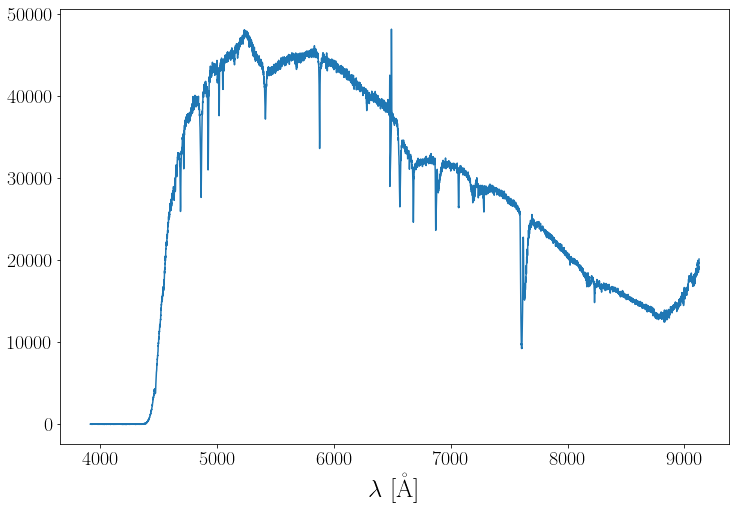

In [101]:
Flux_folder = 'keck_deimos_pypeit/Fluxing/'
Wav = []
S = []
plt.figure(figsize=(12, 8))
#for i in np.arange(41, 45):
f = fits.open(Flux_folder + 'Keck_DEIMOS_sens.fits')
print(f.info())
sens = f[1].data
print(sens.dtype)
wav = np.array(sens['SENS_WAVE'])
s = sens['SENS_COUNTS_PER_ANG']
S.append(s)
plt.plot(wav[wav!=0], s[wav!=0])
Wav.append(sens['SENS_WAVE'])
#plt.xlim(8000, 25500)
plt.xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
#plt.show()
f.close()
#Wav = np.mean(Wav, axis=0)
#S = np.mean(S, axis=1)
#Wav.shape

## Calibrated spectrum for each exposure

### Standard star: HZ44

spec1d_d0331_0030-HZ44_DEIMOS_20220331T104910.934.fits
Filename: keck_deimos_pypeit/Science/spec1d_d0331_0030-HZ44_DEIMOS_20220331T104910.934.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  SPAT0931-SLIT0947-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  2  SPAT0931-SLIT0948-DET07    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  3  DET03-DETECTOR    1 BinTableHDU     34   1R x 2C   [1D, 1D]   
  4  DET07-DETECTOR    1 BinTableHDU     34   1R x 2C   [1D, 1D]   
None


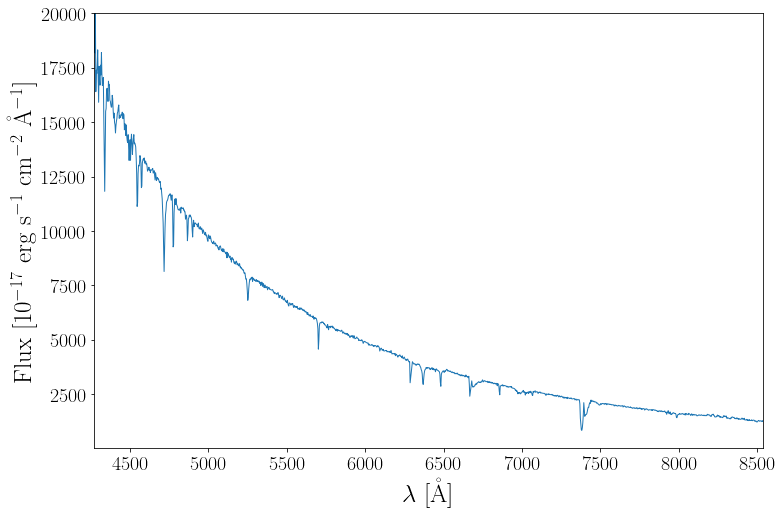

spec1d_d0331_0029-HZ44_DEIMOS_20220331T104558.694.fits
Filename: keck_deimos_pypeit/Science/spec1d_d0331_0029-HZ44_DEIMOS_20220331T104558.694.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   ()      
  1  SPAT0726-SLIT0736-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  2  SPAT0725-SLIT0736-DET07    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  3  DET03-DETECTOR    1 BinTableHDU     34   1R x 2C   [1D, 1D]   
  4  DET07-DETECTOR    1 BinTableHDU     34   1R x 2C   [1D, 1D]   
None


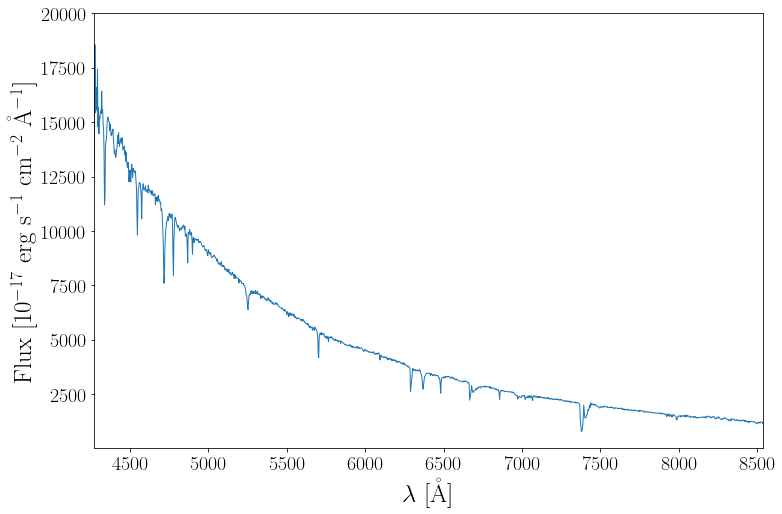

In [139]:
for m, l in enumerate(ls_cal):
    plt.figure(figsize=(12, 8))
    print(l)
    for k in np.arange(1):
        f = fits.open(Sci_folder + l)
        print(f.info())
        #break
        specdata1 = f[1].data
        specdata2 = f[2].data
        wav = np.append(specdata1['OPT_WAVE'], specdata2['OPT_WAVE'])
        #print(specdata)
        flux = np.append(specdata1['OPT_FLAM'], specdata2['OPT_FLAM'])
        f.close()
        plt.plot(wav[::5] / (1 + 0.0307), flux[::5], linewidth=1)
        plt.xlim(4400 / (1 + 0.0307), 8800 / (1 + 0.0307))
        plt.ylim(1e1, 2e4)
        plt.xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
        plt.ylabel(
            r'$\mathrm{Flux}\ [10^{-17}\ \mathrm{erg}\ \mathrm{s}^{-1}\ \mathrm{cm}^{-2}\ \mathrm{\mathring{A}}^{-1}]$'
        )
    plt.show()

### SN2020jgb_host

spec1d_d0331_0043-SN2020jgb_host_DEIMOS_20220331T142045.859.fits
Filename: keck_deimos_pypeit/Science/spec1d_d0331_0043-SN2020jgb_host_DEIMOS_20220331T142045.859.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      50   ()      
  1  SPAT0243-SLIT0314-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  2  SPAT0574-SLIT0525-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  3  SPAT0726-SLIT0736-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  4  SPAT0994-SLIT0947-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D,

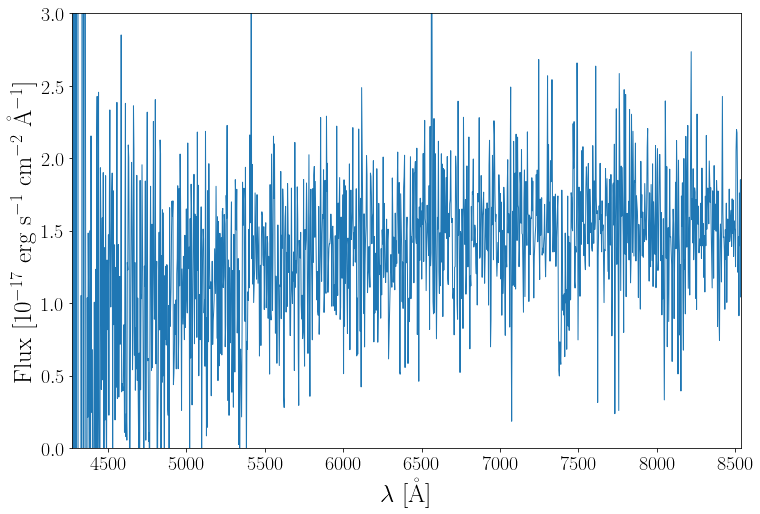

spec1d_d0331_0044-SN2020jgb_host_DEIMOS_20220331T143516.944.fits
Filename: keck_deimos_pypeit/Science/spec1d_d0331_0044-SN2020jgb_host_DEIMOS_20220331T143516.944.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      49   ()      
  1  SPAT0243-SLIT0314-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  2  SPAT0574-SLIT0525-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  3  SPAT0725-SLIT0736-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  4  SPAT0241-SLIT0313-DET07    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D,

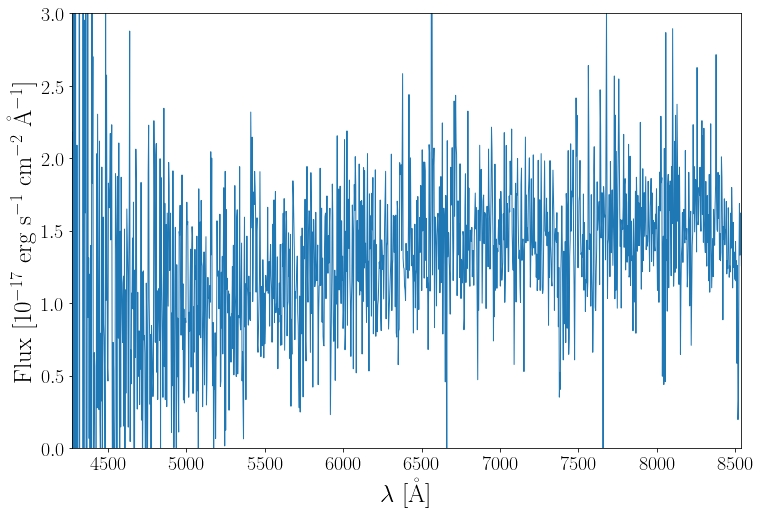

spec1d_d0331_0041-SN2020jgb_host_DEIMOS_20220331T135136.605.fits
Filename: keck_deimos_pypeit/Science/spec1d_d0331_0041-SN2020jgb_host_DEIMOS_20220331T135136.605.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   ()      
  1  SPAT0243-SLIT0314-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  2  SPAT0574-SLIT0525-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  3  SPAT0726-SLIT0736-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  4  SPAT0241-SLIT0313-DET07    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D,

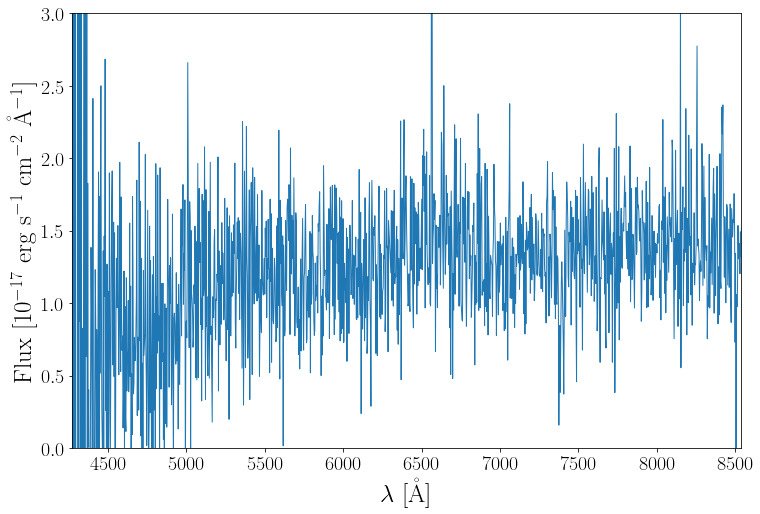

spec1d_d0331_0042-SN2020jgb_host_DEIMOS_20220331T140617.366.fits
Filename: keck_deimos_pypeit/Science/spec1d_d0331_0042-SN2020jgb_host_DEIMOS_20220331T140617.366.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      49   ()      
  1  SPAT0243-SLIT0314-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  2  SPAT0574-SLIT0525-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  3  SPAT0726-SLIT0736-DET03    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  4  SPAT0241-SLIT0313-DET07    1 BinTableHDU     92   4096R x 28C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D,

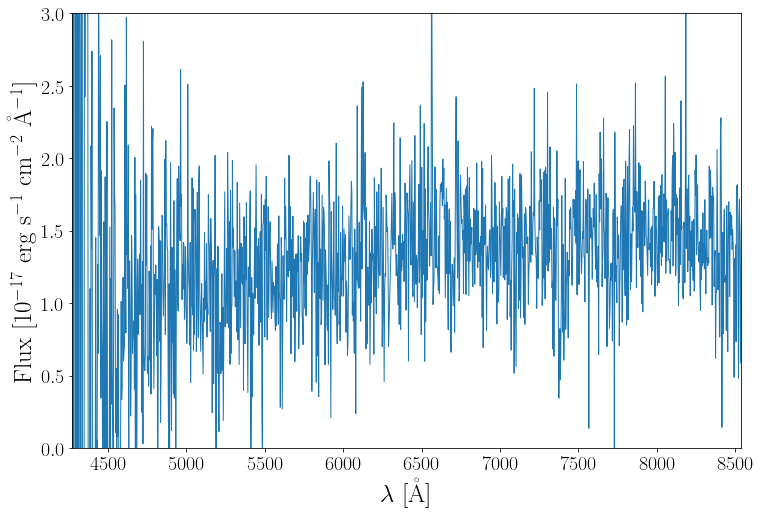

In [177]:
for m, l in enumerate(ls):
    plt.figure(figsize=(12, 8))
    print(l)
    for k in np.arange(1):
        f = fits.open(Sci_folder + l)
        print(f.info())
        #break
        specdata1 = f[3].data
        if m > 0:
            specdata2 = f[6].data
        else:
            specdata2 = f[7].data
        wav = np.append(specdata1['OPT_WAVE'], specdata2['OPT_WAVE'])
        #print(specdata)
        flux = np.append(specdata1['OPT_FLAM'], specdata2['OPT_FLAM'])
        f.close()
        plt.plot(wav[::5] / (1 + 0.0307), flux[::5], linewidth=1)
        plt.xlim(4400 / (1 + 0.0307), 8800 / (1 + 0.0307))
        plt.ylim(0, 3)
        plt.xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
        plt.ylabel(
            r'$\mathrm{Flux}\ [10^{-17}\ \mathrm{erg}\ \mathrm{s}^{-1}\ \mathrm{cm}^{-2}\ \mathrm{\mathring{A}}^{-1}]$'
        )
    plt.show()

## Coadding

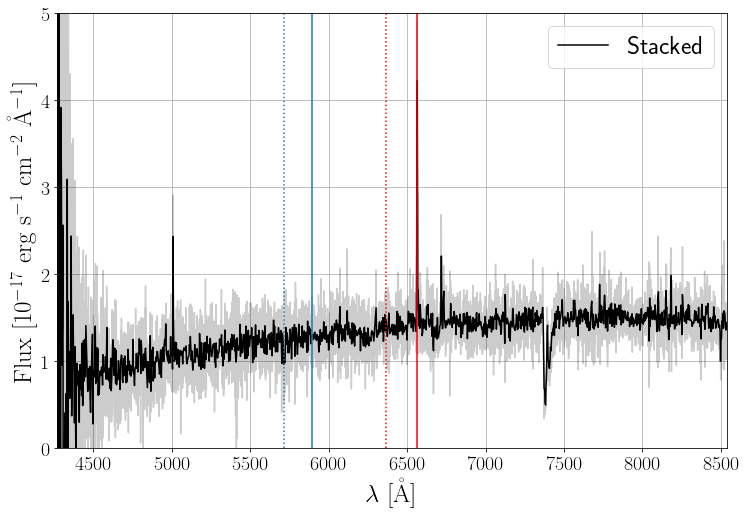

In [181]:
Coadd_folder = 'keck_deimos_pypeit/Coadding/'
f = fits.open(Coadd_folder + 'SN2020jgb_host_coadd.fits')
specdata = f[1].data
f.close()
plt.figure(figsize=(12, 8))
wav = specdata['wave']
flux = specdata['flux']
unc = specdata['ivar']**.5
out = data_binning(np.array(
    [specdata['wave'], specdata['flux'], specdata['ivar']**.5]).T,
                   size=3)
wav1, flux1 = out[:, 0], out[:, 1]
plt.plot(wav / (1 + 0.0307), flux, color='k', alpha=0.2)
plt.plot(wav1 / (1 + 0.0307), flux1, color='k', label='Stacked')
#plt.fill_between(wav, flux-unc, flux+unc, color='0.9', alpha=1)
#plt.xlim(18000, 20000)
plt.xlim(4400 / (1 + 0.0307), 8800 / (1 + 0.0307))
plt.ylim(0, 5)
plt.xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
plt.ylabel(
    r'$\mathrm{Flux}\ [10^{-17}\ \mathrm{erg}\ \mathrm{s}^{-1}\ \mathrm{cm}^{-2}\ \mathrm{\mathring{A}}^{-1}]$'
)
plt.legend()
plt.grid()
plt.axvline(5893 / (1 + 0.0307), linestyle=':')
plt.axvline(5893)
plt.axvline(6562 / (1 + 0.0307), color='r', linestyle=':')
plt.axvline(6562, color='r')

## Telluric correction

/Users/chang/Desktop/SNIa/SN2020jgb/spectroscopy/Host_DEIMOS_reduction/../../tools/data_binning.py:22: RuntimeWarning: invalid value encountered in true_divide
  weight_mag = (temp[arg, 1] / temp[arg, 2]**2) / \
/Users/chang/Desktop/SNIa/SN2020jgb/spectroscopy/Host_DEIMOS_reduction/../../tools/data_binning.py:23: RuntimeWarning: divide by zero encountered in power
  (temp[arg, 2]**(-2)).mean()


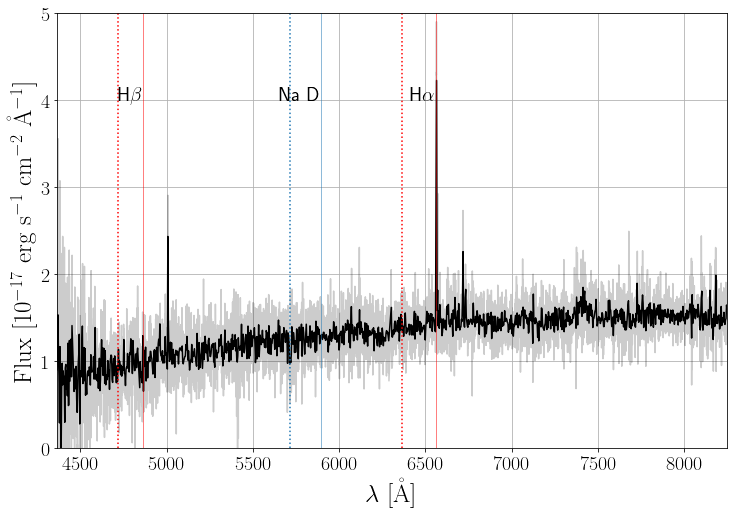

In [192]:
Tell_folder = 'keck_deimos_pypeit/Telluric/'
f = fits.open(Tell_folder + 'SN2020jgb_host_coadd_tellcorr.fits')
fmodel = fits.open(Tell_folder + 'SN2020jgb_host_coadd_tellmodel.fits')
specdata = f[1].data
model = fmodel[1].data
f.close()
fmodel.close()
plt.figure(figsize=(12, 8))
wav = specdata['wave']
flux = specdata['flux']
out = data_binning(np.array(
    [specdata['wave'], specdata['flux'], specdata['ivar']**.5]).T,
                   size=3)
wav1, flux1 = out[:, 0], out[:, 1]
plt.plot(wav / (1 + 0.0307), flux, color='k', alpha=0.2)
plt.plot(wav1 / (1 + 0.0307),
         flux1,
         color='k',
         label=r'$\mathrm{Telluric}\ \mathrm{corrected}$')
plt.axvline(5893 / (1 + 0.0307), linestyle=':')
plt.axvline(5893, linewidth=0.5)
plt.text(5893, 4, 'Na D', ha='right', fontsize=20)
plt.axvline(6562 / (1 + 0.0307), color='r', linestyle=':')
plt.axvline(6562, color='r', linewidth=0.5)
plt.text(6562, 4, r'H$\alpha$', ha='right', fontsize=20)
plt.axvline(4861 / (1 + 0.0307), color='r', linestyle=':')
plt.axvline(4861, color='r', linewidth=0.5)
plt.text(4861, 4, r'H$\beta$', ha='right', fontsize=20)
#plt.axvline(6300, color='darkgreen')
plt.xlim(4500 / (1 + 0.0307), 8500 / (1 + 0.0307))
plt.ylim(0, 5)
plt.xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
plt.ylabel(
    r'$\mathrm{Flux}\ [10^{-17}\ \mathrm{erg}\ \mathrm{s}^{-1}\ \mathrm{cm}^{-2}\ \mathrm{\mathring{A}}^{-1}]$'
)
#plt.legend()
plt.grid()
#plt.savefig('SN2020jgb_Gemini_GNIRS.pdf', bbox_inches='tight')
plt.show()

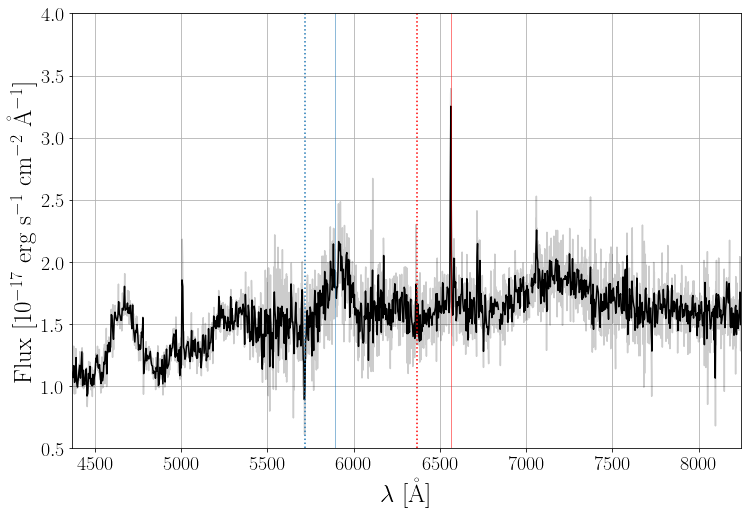

In [186]:
plt.figure(figsize=(12, 8))

obs = np.loadtxt('../SN2020jgb/ZTF20aayhacx_20200915_Keck1_v2.ascii')
out = data_binning(obs, size=3)
wav1, flux1 = out[:, 0], out[:, 1]
plt.plot(wav1 / (1 + 0.0307), flux1 / 1e-17, color='k')
plt.plot(obs[:, 0] / (1 + 0.0307), obs[:, 1] / 1e-17, color='k', alpha=0.2)
plt.axvline(5893 / (1 + 0.0307), linestyle=':')
plt.axvline(5893, linewidth=0.5)
plt.axvline(6562 / (1 + 0.0307), color='r', linestyle=':')
plt.axvline(6562, color='r', linewidth=0.5)
#plt.axvline(6300, color='darkgreen')
plt.xlim(4500 / (1 + 0.0307), 8500 / (1 + 0.0307))
plt.ylim(0.5, 4)
plt.xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
plt.ylabel(
    r'$\mathrm{Flux}\ [10^{-17}\ \mathrm{erg}\ \mathrm{s}^{-1}\ \mathrm{cm}^{-2}\ \mathrm{\mathring{A}}^{-1}]$'
)
plt.grid()

## Galactic Extinction

/Users/chang/Desktop/SNIa/SN2020jgb/spectroscopy/Host_DEIMOS_reduction/../../tools/data_binning.py:22: RuntimeWarning: invalid value encountered in true_divide
  weight_mag = (temp[arg, 1] / temp[arg, 2]**2) / \
/Users/chang/Desktop/SNIa/SN2020jgb/spectroscopy/Host_DEIMOS_reduction/../../tools/data_binning.py:23: RuntimeWarning: divide by zero encountered in power
  (temp[arg, 2]**(-2)).mean()


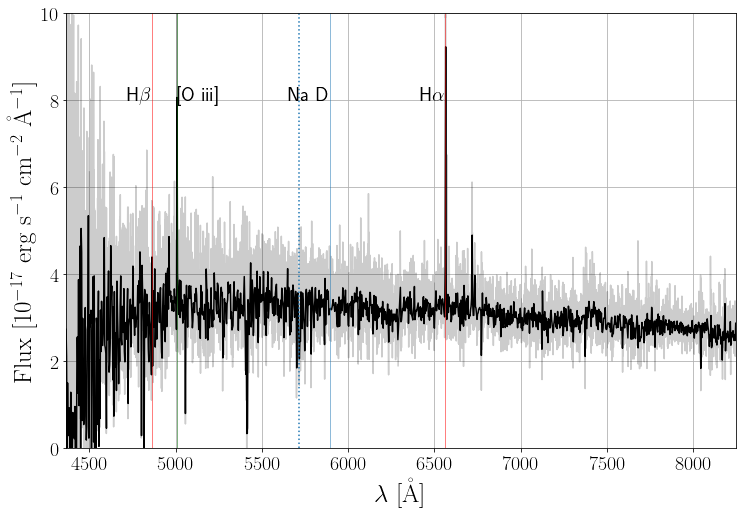

In [239]:
ebv = 0.404
rv = 3.1

Tell_folder = 'keck_deimos_pypeit/Telluric/'
f = fits.open(Tell_folder + 'SN2020jgb_host_coadd_tellcorr.fits')
fmodel = fits.open(Tell_folder + 'SN2020jgb_host_coadd_tellmodel.fits')
specdata = f[1].data
model = fmodel[1].data
f.close()
fmodel.close()
wav = specdata['wave']
flux = specdata['flux']
unc = specdata['flux']*0.15#specdata['ivar']**.5
X = np.array([wav, flux, unc]).T.copy()
np.savetxt('../SN2020jgb/host_20220331_Keck2_corrected.ascii', X, fmt='%.4f')
out = data_binning(X,
                   size=3)
wav1, flux1 = out[:, 0], out[:, 1]

E = 10**(0.4 * calALambda(wav, rv, ebv))
E1 = 10**(0.4 * calALambda(wav1, rv, ebv))

plt.figure(figsize=(12, 8))
plt.plot(wav / (1 + 0.0307), flux * E, color='k', alpha=0.2)
plt.plot(wav1 / (1 + 0.0307),
         flux1 * E1,
         color='k',
         label=r'$\mathrm{Telluric}\ \mathrm{corrected}$')
plt.axvline(5893 / (1 + 0.0307), linestyle=':')
plt.axvline(5893, linewidth=0.5)
plt.text(5893, 8, 'Na D', ha='right', fontsize=20)
plt.axvline(6562, color='r', linewidth=0.5)
plt.text(6562, 8, r'H$\alpha$', ha='right', fontsize=20)
plt.axvline(4861, color='r', linewidth=0.5)
plt.text(4861, 8, r'H$\beta$', ha='right', fontsize=20)
plt.axvline(5007, color='darkgreen', linewidth=0.5)
plt.text(5007, 8, r'[O iii]', ha='left', fontsize=20)
#plt.axvline(6300, color='darkgreen')
plt.xlim(4500 / (1 + 0.0307), 8500 / (1 + 0.0307))
#plt.xlim(4500, 7000)
plt.ylim(0, 10)
plt.xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
plt.ylabel(
    r'$\mathrm{Flux}\ [10^{-17}\ \mathrm{erg}\ \mathrm{s}^{-1}\ \mathrm{cm}^{-2}\ \mathrm{\mathring{A}}^{-1}]$'
)
#plt.legend()
plt.grid()
#plt.savefig('SN2020jgb_Gemini_GNIRS.pdf', bbox_inches='tight')
plt.show()

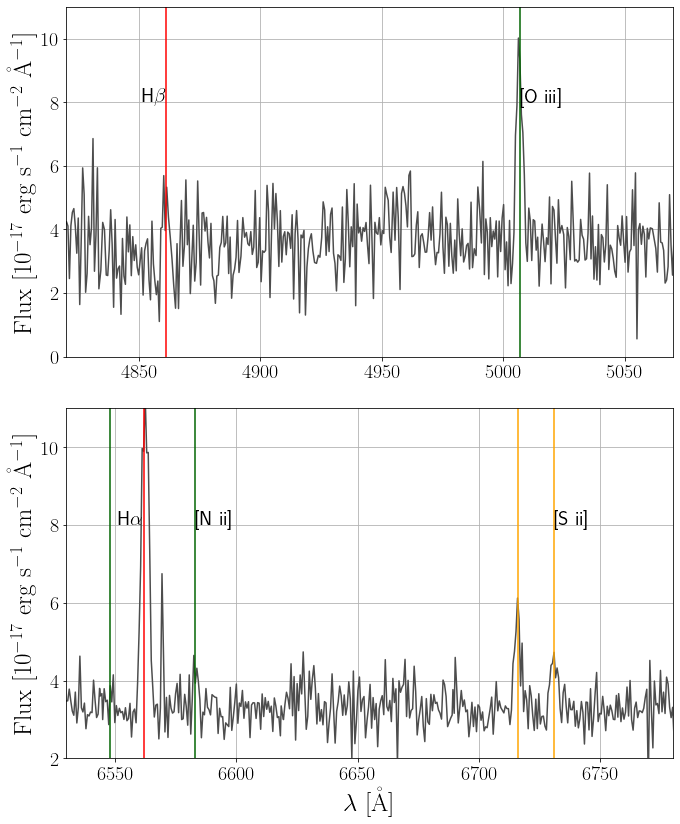

In [233]:
f, ax = plt.subplots(2, 1, figsize=(10, 12))
for a in ax:
    a.plot(wav / (1 + 0.0310), flux * E, color='0.3')
    '''a.plot(wav1 / (1 + 0.0307),
             flux1 * E1,
             color='k',
             label=r'$\mathrm{Telluric}\ \mathrm{corrected}$')
    '''
    a.grid()
    a.set_ylabel(
        r'$\mathrm{Flux}\ [10^{-17}\ \mathrm{erg}\ \mathrm{s}^{-1}\ \mathrm{cm}^{-2}\ \mathrm{\mathring{A}}^{-1}]$'
    )
ax[0].axvline(4861, color='r')
ax[0].text(4861, 8, r'H$\beta$', ha='right', fontsize=20)
ax[0].axvline(5007, color='darkgreen')
ax[0].text(5007, 8, r'[O iii]', ha='left', fontsize=20)
ax[0].set_xlim(4820, 5070)
ax[0].set_ylim(0, 11)
ax[1].axvline(6562, color='r')
ax[1].text(6562, 8, r'H$\alpha$', ha='right', fontsize=20)
ax[1].axvline(6583, color='darkgreen')
ax[1].axvline(6548, color='darkgreen')
ax[1].text(6583, 8, r'[N ii]', ha='left', fontsize=20)
ax[1].axvline(6716, color='orange')
ax[1].axvline(6731, color='orange')
ax[1].text(6731, 8, r'[S ii]', ha='left', fontsize=20)
ax[1].set_xlim(6530, 6780)
ax[1].set_ylim(2, 11)

ax[1].set_xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
#plt.legend()
#plt.savefig('SN2020jgb_Gemini_GNIRS.pdf', bbox_inches='tight')
f.tight_layout()
plt.show()

[O iii]/[H $\beta$] $\sim$ 7/3 $\Rightarrow$ log$\sim$0.4

[N ii]/[H $\alpha$] $\sim$ 1.5/8 $\Rightarrow$ log$\sim$-0.7